<a href="https://colab.research.google.com/github/nataschaak/ImageSegmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import pandas as pd

In [ ]:
import numpy as np # linear algebra

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
dir = '/content/drive/MyDrive/segm_dataset/'
#Метка - это маска в формате png, картинка - это тренировочные данные, т.е. x_train - картинка, y_train - маска-лейбл
train_img = np.load(dir + '500_train_img.npy', allow_pickle=True)
print(train_img.shape)
train_mask = np.load(dir + '500_train_mask.npy', allow_pickle=True)
print(train_mask.shape)

val_img = np.load(dir + '500_val_img.npy', allow_pickle=True)
print(val_img.shape)
val_mask = np.load(dir + '500_val_mask.npy', allow_pickle=True)
print(val_mask.shape)

#img_height = train_img.shape[1]
#img_width = train_img.shape[2]
#img_channels = train_img.shape[3]
#num_imgs = train_img.shape[0]

(500, 256, 256, 3)
(500, 256, 256, 12)
(50, 256, 256, 3)
(50, 256, 256, 12)


In [ ]:
new_train_img = train_img[48:64:]
print(new_train_img.shape)
np.save('/content/drive/MyDrive/segm_dataset/16_train_img', new_train_img)

new_train_mask = train_mask[48:64:]
print(new_train_mask.shape)
np.save('/content/drive/MyDrive/segm_dataset/16_train_mask', new_train_mask)

new_val_img = val_img[12:16:]
print(new_val_img.shape)
np.save('/content/drive/MyDrive/segm_dataset/4_val_img', new_val_img)

new_val_mask = val_mask[12:16:]
print(new_val_mask.shape)
np.save('/content/drive/MyDrive/segm_dataset/4_val_mask', new_val_mask)

(16, 256, 256, 3)
(16, 256, 256, 12)
(4, 256, 256, 3)
(4, 256, 256, 12)


In [ ]:
def keras_generator(gen_img, gen_mask, step, batch_size):
  while True:
    x_batch=[]
    y_batch=[]
    begin_index = batch_size*step #16
    #print(begin_index)
    end_index = batch_size*(step+1) #32
    #print(end_index)
    # обрезка массива до нужных размеров
    gen_img = gen_img[begin_index:end_index:] #16-32
    gen_mask = gen_mask[begin_index:end_index:] #16-32
    #print(gen_img.shape)
    #print(gen_mask.shape)

    for i in range(batch_size):
      img = gen_img[i]
      mask = gen_mask[i]
      x_batch += [img]
      y_batch += [mask]

    x_batch=np.array(x_batch)/255.0
    y_batch=np.array(y_batch)

    yield x_batch, y_batch

In [ ]:

#Проверка работы функции keras_generator
batch_train = 16
batch_val = 4
step=1
for x, y in keras_generator(train_img, train_mask, step, batch_train):
  break 
print(x.shape, y.shape)

(16, 256, 256, 3)
(16, 256, 256, 12)
(16, 256, 256, 3) (16, 256, 256, 12)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model, layers
from keras.layers import Dense, GlobalAveragePooling2D, 
Dropout, UpSampling2D, Conv2D, Activation

base_model = VGG16(weights='imagenet', 
                   input_shape=(256,256,3), include_top=False)
base_out = base_model.output

up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(12, (1, 1))(up)
conv = Activation('sigmoid')(conv)

model = Model(inputs=base_model.input, outputs=conv)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
filepath = '/content/drive/MyDrive/model3.h5'
checkpoints = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',
                                         save_best_only=True,
                                         mode='max',
                                         save_freq=1)
callback_list = [checkpoints]
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(adam, 'binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [ ]:
#Загрузили новые данные
dir = '/content/drive/MyDrive/segm_dataset/'
#Метка - это маска в формате png, картинка - это тренировочные данные, т.е. x_train - картинка, y_train - маска-лейбл
train_img = np.load(dir + '16_train_img.npy', allow_pickle=True)
print(train_img.shape)
train_mask = np.load(dir + '16_train_mask.npy', allow_pickle=True)
print(train_mask.shape)

val_img = np.load(dir + '4_val_img.npy', allow_pickle=True)
print(val_img.shape)
val_mask = np.load(dir + '4_val_mask.npy', allow_pickle=True)
print(val_mask.shape)

(16, 256, 256, 3)
(16, 256, 256, 12)
(4, 256, 256, 3)
(4, 256, 256, 12)


In [ ]:
# ДООБУЧЕНИЕ
from tensorflow.keras import models
# Загрузили модель и веса
filepath = '/content/drive/MyDrive/modelU.h5'
json_file='/content/drive/MyDrive/modelU.json'
with open(json_file, 'r') as f:
    new_model = models.model_from_json(f.read())
new_model.load_weights(filepath)
print("model loaded")

checkpoints = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', save_best_only=True)
callback_list = [checkpoints]
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
new_model.compile(adam, 'binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

batch_train = 16
batch_val = 4
step=0

history = new_model.fit(keras_generator(train_img, train_mask, step, batch_train), 
            validation_data=keras_generator(val_img, val_mask, step, batch_val), 
            epochs=15, verbose='auto',
            callbacks=callback_list, shuffle=True,
            initial_epoch=0, steps_per_epoch=100,
            validation_steps=50, validation_freq=1,
            max_queue_size=10, workers=1,
            use_multiprocessing=False
)
#сохранение весов и самой модели в файл в формате json
model_json = new_model.to_json()
with open("/content/drive/MyDrive/modelU.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/modelU.h5")
print("Saved new_model to disk") 
"""
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = 100
plt.figure(figsize=(10,6), dpi=90)
plt.plot(epochs, val_acc_values, 'b', label='Validation')
plt.plot(epochs, acc_values, 'r', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()"""

model loaded
Epoch 1/15
100/100 [==============================] - 42s 416ms/step - loss: 0.0480 - accuracy: 0.8739 - val_loss: 0.3661 - val_accuracy: 0.3053
Epoch 2/15
100/100 [==============================] - 42s 418ms/step - loss: 0.0241 - accuracy: 0.9151 - val_loss: 0.5790 - val_accuracy: 0.3127
Epoch 3/15
100/100 [==============================] - 42s 417ms/step - loss: 0.0192 - accuracy: 0.9226 - val_loss: 0.6534 - val_accuracy: 0.3128
Epoch 4/15
100/100 [==============================] - 42s 416ms/step - loss: 0.0160 - accuracy: 0.9272 - val_loss: 0.8347 - val_accuracy: 0.3096
Epoch 5/15
100/100 [==============================] - 41s 408ms/step - loss: 0.0149 - accuracy: 0.9287 - val_loss: 0.8398 - val_accuracy: 0.3098
Epoch 6/15
100/100 [==============================] - 41s 415ms/step - loss: 0.0133 - accuracy: 0.9317 - val_loss: 0.9410 - val_accuracy: 0.3065
Epoch 7/15
100/100 [==============================] - 41s 407ms/step - loss: 0.0132 - accuracy: 0.9314 - val_loss: 0.

"\nhistory_dict = history.history\nacc_values = history_dict['accuracy']\nval_acc_values = history_dict['val_accuracy']\nepochs = 100\nplt.figure(figsize=(10,6), dpi=90)\nplt.plot(epochs, val_acc_values, 'b', label='Validation')\nplt.plot(epochs, acc_values, 'r', label='Train')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.show()"

In [ ]:
#Основное обучение
batch_train = 16
batch_val = 4
step=0 
model.fit(keras_generator(train_img, train_mask, step, batch_train), 
            validation_data=keras_generator(val_img, val_mask, step, batch_val), 
            epochs=10,
            verbose='auto',
            callbacks=callback_list,
            shuffle=True,
            initial_epoch=0,
            steps_per_epoch=100,
            validation_steps=50,
            validation_freq=1,
            max_queue_size=10,
            workers=1,
            use_multiprocessing=False
)
#сохранение самой модели в файл в формате YAML
model_json = model.to_json()
with open("/content/drive/My Drive/model3.json", "w") as json_file:
    json_file.write(model_json)
#сохранили веса
model.save_weights("/content/drive/My Drive/model3.h5")
print("Saved model to disk") 

In [ ]:
for x, y in keras_generator(train_img, train_mask, step, 110):
  break 

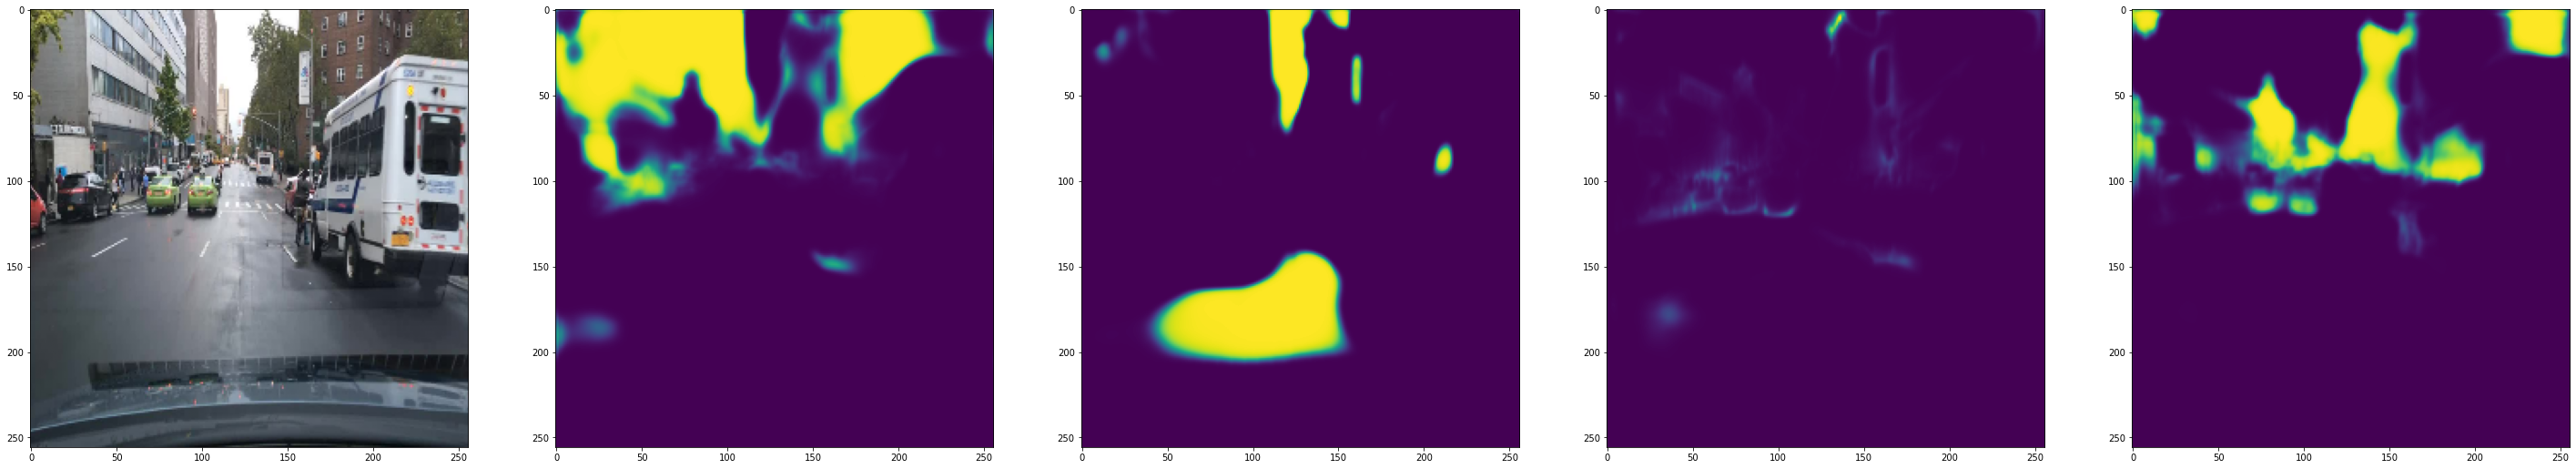

In [ ]:
# 0 - здания, 1 - небо, 2 - фонари, 3 - деревья, 4 - дорожные знаки, 5 - мотоциклы и велики, 6 - дорога, 7 - тротуар, 8 - светофоры,
# 9 - забор, 10 - трава и кусты у дороги, 11 - грузовики и автобусы


pred = model.predict(x)
im_id = 30
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(50,50))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id,...,0])
axes[2].imshow(pred[im_id,...,1])
axes[3].imshow(pred[im_id,...,2])
axes[4].imshow(pred[im_id,...,3])

plt.show()


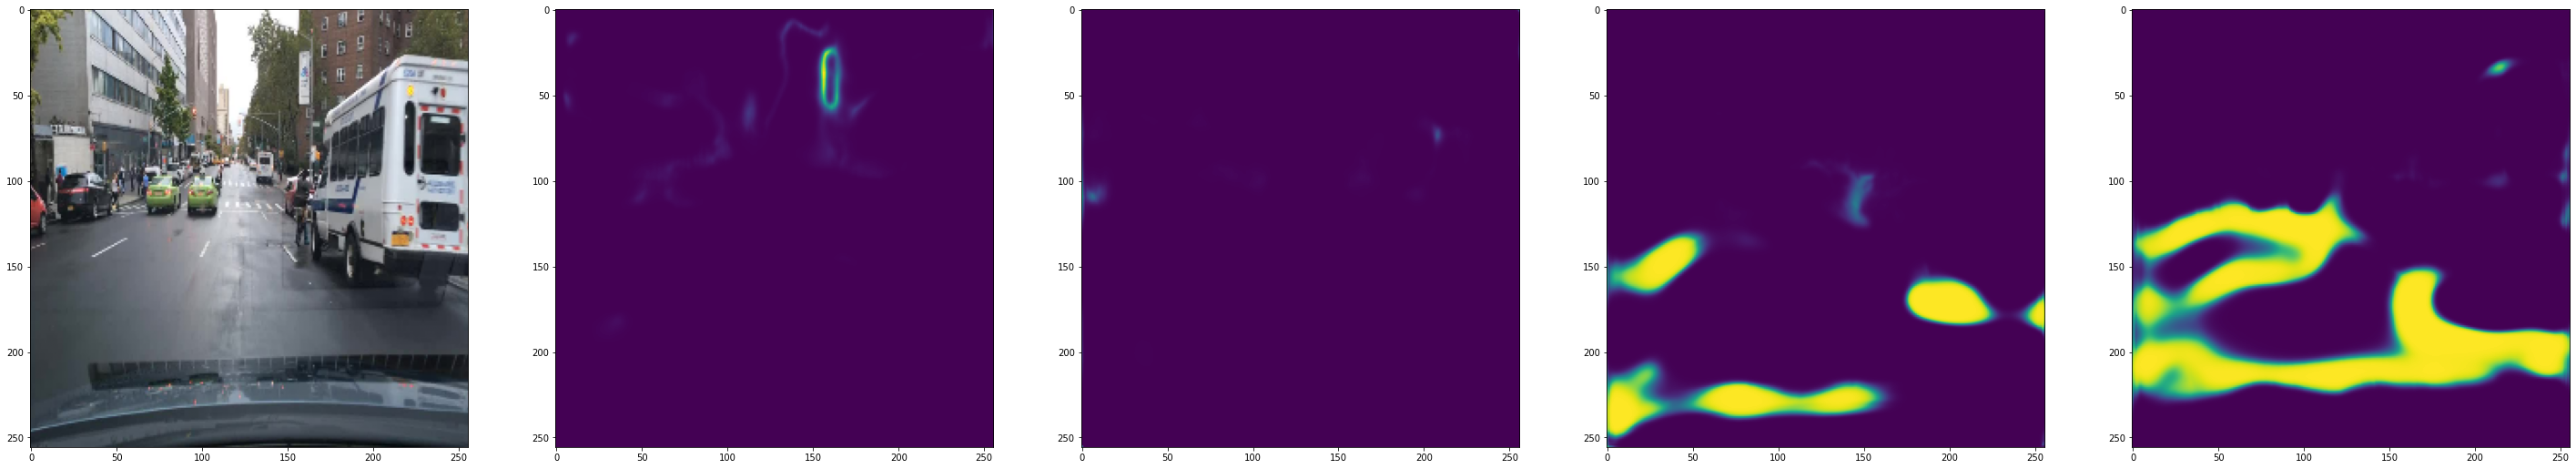

In [ ]:
pred = model.predict(x)
im_id =30
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(50,50))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id,...,4])
axes[2].imshow(pred[im_id,...,5])
axes[3].imshow(pred[im_id,...,6])
axes[4].imshow(pred[im_id,...,7])

In [ ]:
pred = model.predict(x)

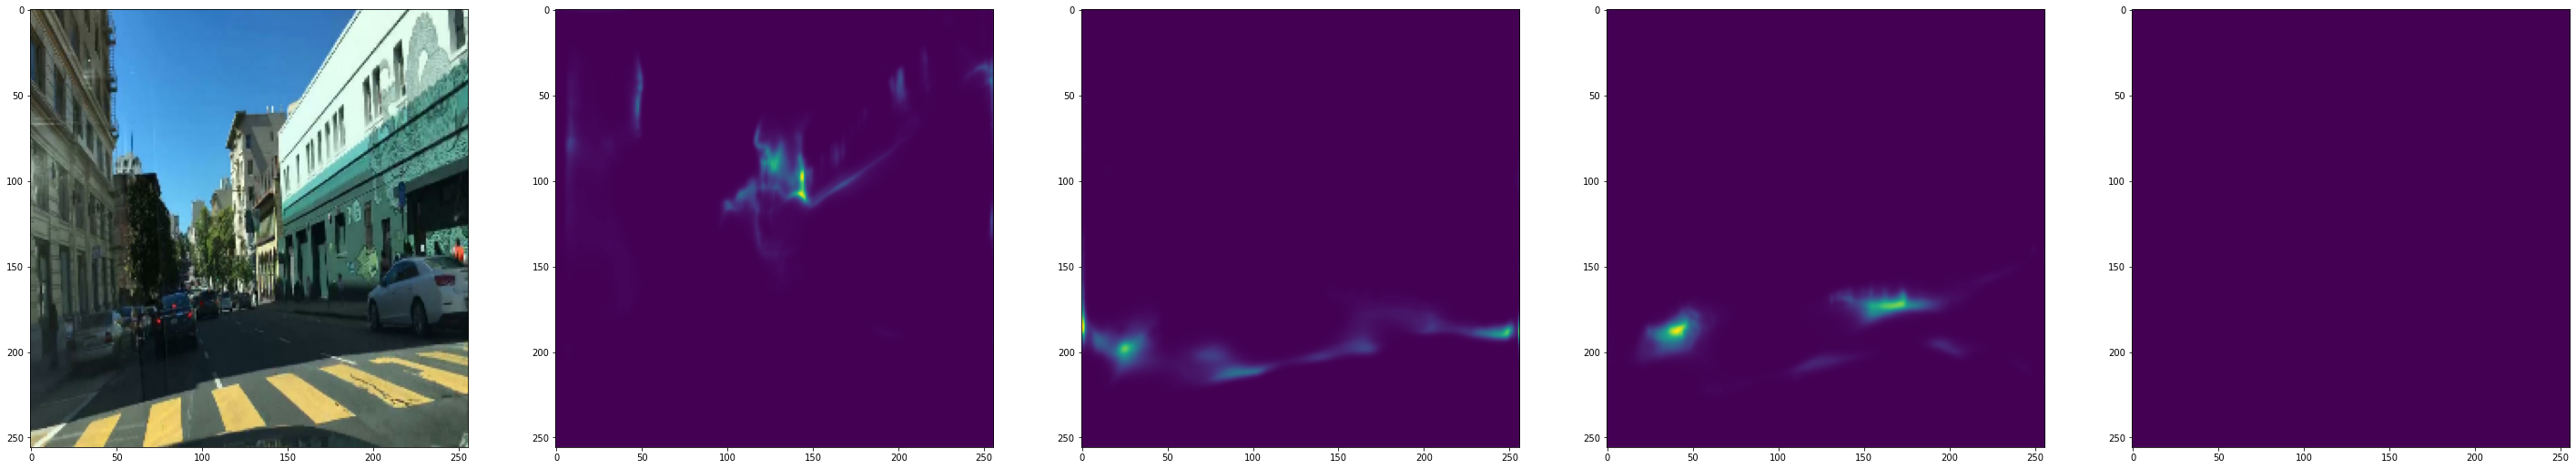

In [ ]:

im_id = 35
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(50,50))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id,...,8])
axes[2].imshow(pred[im_id,...,9])
axes[3].imshow(pred[im_id,...,10])
axes[4].imshow(pred[im_id,...,11])

In [ ]:
#U-NET
from tensorflow.keras import Model, layers
from keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, MaxPooling2D, UpSampling2D,Conv2D, Activation, GlobalAveragePooling2D, Input

inp = Input(shape=(256,256,3))
#---------------DOWN--------------------------------------------------
conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)
#--------------UP---------------------------------------------------
#UP_1
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])
conv_up_1_1 = Conv2D(256,(3,3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256,(3,3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)

# UP_2
up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])
conv_up_2_1 = Conv2D(128,(3,3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128,(3,3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)

# UP_3
up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])
conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)

# UP_4
up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(12, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)

model = Model(inputs=inp, outputs=result)


In [ ]:
filepath = '/content/drive/MyDrive/modelU.h5'
checkpoints = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',
                                         save_best_only=True,
                                         mode='max',
                                         save_freq=1)
callback_list = [checkpoints]
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(adam, 'binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [ ]:
#Основное обучение UNET
batch_train = 16
batch_val = 4
step=0 #(всего должно быть 8 шагов, так как 128:8=16)
model.fit(keras_generator(train_img, train_mask, step, batch_train), 
            validation_data=keras_generator(val_img, val_mask, step, batch_val), 
            epochs=15,
            verbose='auto',
            callbacks=callback_list,
            shuffle=True,
            initial_epoch=0,
            steps_per_epoch=100,
            validation_steps=50,
            validation_freq=1,
            max_queue_size=10,
            workers=1,
            use_multiprocessing=False
)
#сохранение самой модели в файл в формате YAML
model_json = model.to_json()
with open("/content/drive/My Drive/modelU.json", "w") as json_file:
    json_file.write(model_json)
#сохранили веса
model.save_weights("/content/drive/My Drive/modelU.h5")
print("Saved model to disk") 

In [ ]:
for x, y in keras_generator(train_img, train_mask, step, batch_train):
  break 

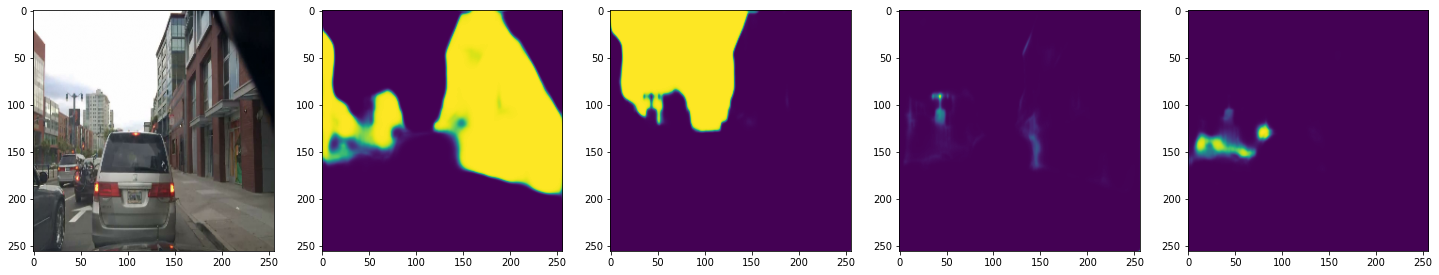

In [ ]:
# 0 - здания, 1 - небо, 2 - фонари, 3 - деревья, 4 - дорожные знаки, 5 - мотоциклы и велики, 6 - дорога, 7 - тротуар, 8 - светофоры,
# 9 - забор, 10 - трава и кусты у дороги, 11 - грузовики и автобусы
# Загрузили модель и веса
"""filepath = '/content/drive/MyDrive/model3.h5'
json_file='/content/drive/MyDrive/model3.json'
with open(json_file, 'r') as f:
    new_model = models.model_from_json(f.read())
new_model.load_weights(filepath)
print("model loaded")"""

pred = model.predict(x)
im_id = 10
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id,...,0])
axes[2].imshow(pred[im_id,...,1])
axes[3].imshow(pred[im_id,...,2])
axes[4].imshow(pred[im_id,...,3])

plt.show()

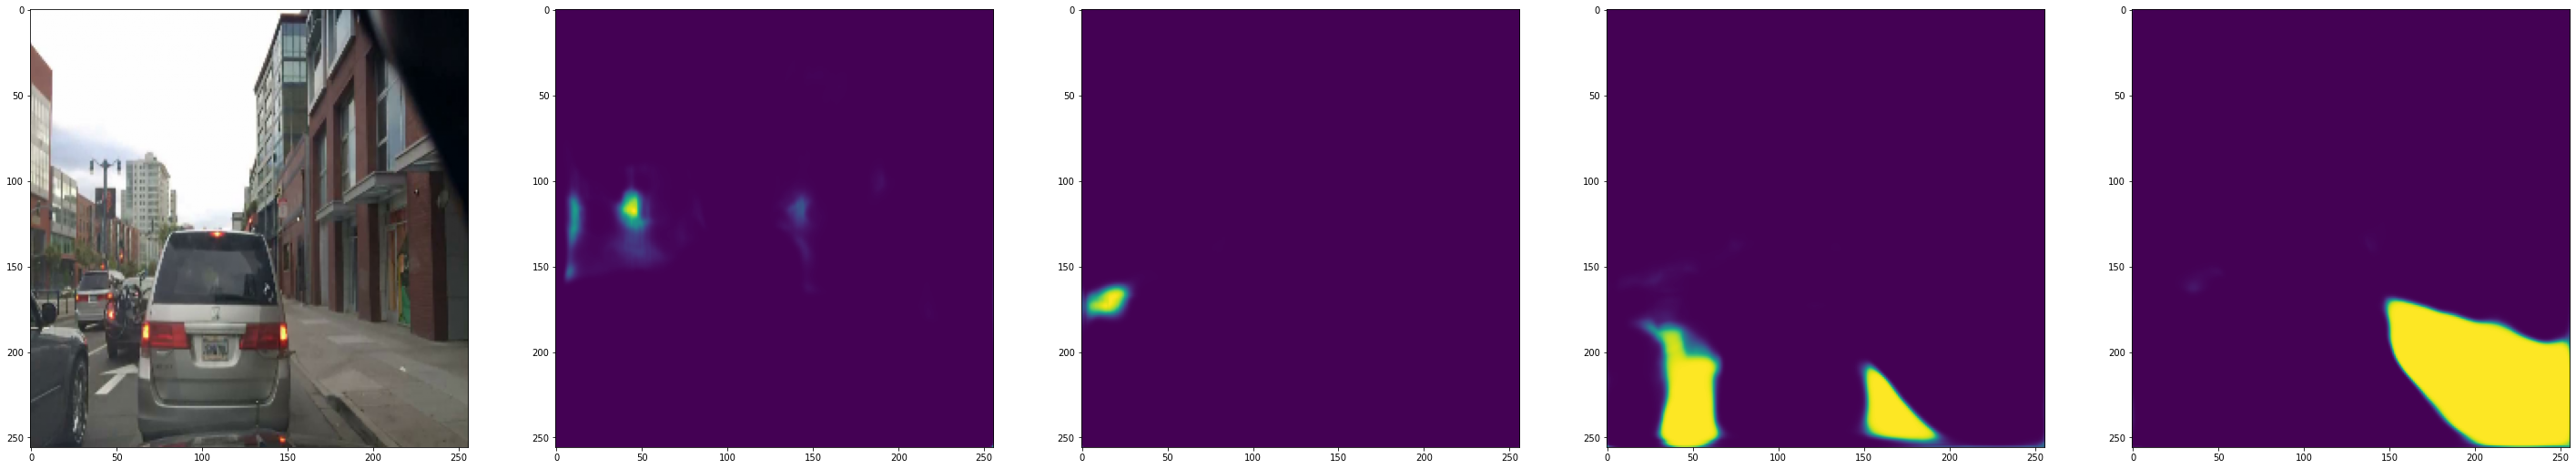

In [ ]:
pred = model.predict(x)
im_id = 10
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(50,50))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id,...,4])
axes[2].imshow(pred[im_id,...,5])
axes[3].imshow(pred[im_id,...,6])
axes[4].imshow(pred[im_id,...,7])

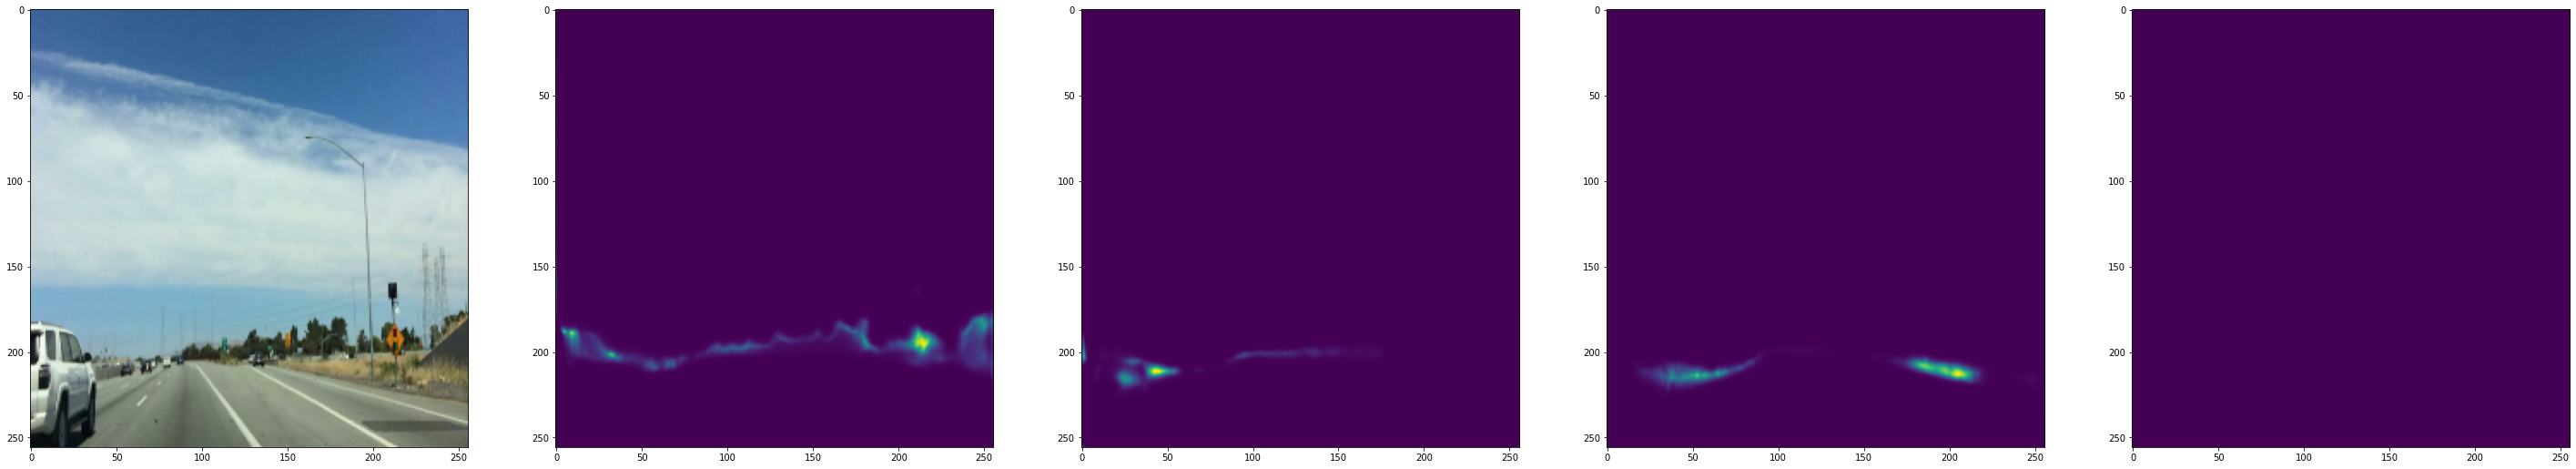

In [ ]:
pred = model.predict(x)
im_id = 14
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(50,50))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id,...,8])
axes[2].imshow(pred[im_id,...,9])
axes[3].imshow(pred[im_id,...,10])
axes[4].imshow(pred[im_id,...,11])